In [1]:
import numpy as np
import matplotlib.pyplot as plt
from celmech.disturbing_function import df_coefficient_Ctilde
from celmech.disturbing_function import evaluate_df_coefficient_dict
from celmech.disturbing_function import laplace_b as b
import scipy.optimize as opt

In [2]:
def b1(alpha):
    return b(1.5, 1, 0, alpha)
def b2(alpha):
    return b(1.5, 2, 0, alpha)

In [56]:
def Mprime(alpha, mass):
    m1, m2, m3 = mass
    m_tot = m1+m2+m3
    alpha12, alpha23 = alpha
    alpha13 = alpha12*alpha23
    
    R = np.array([[np.sqrt(m1/m_tot), np.sqrt(m2/m_tot), np.sqrt(m3/m_tot)],
             [-np.sqrt(m3/(m1+m3)), 0, np.sqrt(m1/(m1+m3))],
             [np.sqrt(m1*m2/(m1+m3)/m_tot), -np.sqrt((m1+m3)/m_tot), np.sqrt(m2*m3/(m1+m3)/m_tot)]])
       
    M = np.array([[b1(alpha12)*m2+b1(alpha13)*m3, -b2(alpha12)*np.sqrt(m1*m2), -b2(alpha13)*np.sqrt(m1*m3)],
             [-b2(alpha12)*np.sqrt(m1*m2), b1(alpha12)*m1+ b1(alpha23)*m3, -b2(alpha23)*np.sqrt(m2*m3)],
             [-b2(alpha13)*np.sqrt(m1*m3), -b2(alpha23)*np.sqrt(m2*m3), b1(alpha13)*m1+b1(alpha23)*m2]])*(-2*alpha12)*np.pi/4
    
    return np.matmul(np.matmul(R, M), np.transpose(R))

In [57]:
Mprime((0.85,0.85),(3e-6,0,3e-6))

array([[-5.93896550e-06, -6.58671790e-22,  0.00000000e+00],
       [ 1.95526536e-21, -6.47072591e-05,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -2.38408100e-04]])

$$ R \cdot \begin{pmatrix}\vec{G_1}\\ \vec{G_2}\\ \vec{G_3} \end{pmatrix} = \begin{pmatrix}\vec{S_1}\\ \vec{S_2}\\ \vec{S_3} \end{pmatrix} $$

In [5]:
def StoG(mass, amp, phi):
    m1, m3 = mass
    A1, A2, A3 = amp
    p1, p2, p3 = phi
    
    e1_x = A1*np.cos(p1) - np.sqrt(m3/m1)*A2*np.cos(p2)
    e2_x = A1*np.cos(p1) - A3*np.cos(p3)
    e3_x = A1*np.cos(p1) + np.sqrt(m1/m3)*A2*np.cos(p2)
    
    e1_y = A1*np.sin(p1) - np.sqrt(m3/m1)*A2*np.sin(p2)
    e2_y = A1*np.sin(p1) - A3*np.sin(p3)
    e3_y = A1*np.sin(p1) + np.sqrt(m1/m3)*A2*np.sin(p2)
    
    e1, e2, e3 = np.sqrt(e1_x**2 + e1_y**2), np.sqrt(e2_x**2 + e2_y**2), np.sqrt(e3_x**2 + e3_y**2)
    pom1, pom2, pom3 = np.arctan2(e1_y,e1_x), np.arctan2(e2_y,e2_x), np.arctan2(e3_y,e3_x)
    
    return (e1, e2, e3), (pom1, pom2, pom3)

In [6]:
def GtoS(alpha, mass, ecc, pomega):
    alpha12, alpha23 = alpha
    alpha13 = alpha12*alpha23
    m1, m3 = mass
    ecc1, ecc2, ecc3 = ecc
    pom1, pom2, pom3 = pomega

    e1_x, e2_x, e3_x = ecc1*np.cos(pom1), ecc2*np.cos(pom2), ecc3*np.cos(pom3)
    e1_y, e2_y, e3_y = ecc1*np.sin(pom1), ecc2*np.sin(pom2), ecc3*np.sin(pom3)
    
    amp1 = 1/(m1+m3) * np.sqrt((m1*e1_y + m3*e3_y)**2 + (m1*e1_x + m3*e3_x)**2)
    amp2 = np.sqrt(m1*m3)/(m1+m3) * np.sqrt((e3_y-e1_y)**2 + (e3_x-e1_x)**2)
    amp3 = 1/(m1+m3) * np.sqrt((m3*(e3_y-e2_y)-m1*(e2_y-e1_y))**2+(m3*(e3_x-e2_x)-m1*(e2_x-e1_x))**2)
    
    phase1 = np.arctan2(m1*e1_y+m3*e3_y, m1*e1_x+m3*e3_x)
    phase2 = np.arctan2(e3_y-e1_y, e3_x-e1_x)
    phase3 = np.arctan2(m3*(e3_y-e2_y)-m1*(e2_y-e1_y), m3*(e3_x-e2_x)-m1*(e2_x-e1_x))
    
    omega2 = (alpha12+alpha13+alpha23)/3 * (m1+m3)/(2*(1-alpha13)**2)
    omega3 = (alpha12+alpha13+alpha23)/3 * (m1/(2*(1-alpha12)**2) + m3/(2*(1-alpha23)**2))
    
    return amp1, amp2, amp3, phase1, phase2, phase3, omega2, omega3

In [7]:
# set A2 to zero
def breathingON1(mass, A3_p):
    m1, m3 = mass
    
    x1 = np.sqrt(m3/m1)
    x2 = 1
    y1 = np.sqrt(m1/m3)
    y2 = 1

    if m1==m3:
        A3_b = A3_p / np.sqrt(2)
        A2_b = A3_b*x2/x1
        theta = np.pi/2
    else:
        def A2(theta):
            return np.fabs(2*A3_p*x2*y2*np.cos(theta) / np.sqrt((x1*y2-x2*y1)**2 + 4*x1*x2*y1*y2*(np.cos(theta))**2))
        def A3(theta):
            return np.fabs(A3_p*(x1*y2-x2*y1) / np.sqrt((x1*y2-x2*y1)**2 + 4*x1*x2*y1*y2*(np.cos(theta))**2))
        def e21_min(theta):
            return -(x1*A2(theta) + x2*A3(theta))**2
        def e32_min(theta):
            return -(y1*A2(theta) + y2*A3(theta))**2
        
        minimizer_kwargs = dict(method="L-BFGS-B", bounds=[(0,2*np.pi)])
        result21 = opt.basinhopping(e21_min, x0=0, minimizer_kwargs=minimizer_kwargs, niter=50)
        result32 = opt.basinhopping(e32_min, x0=0, minimizer_kwargs=minimizer_kwargs, niter=50)
        
        if np.fabs(result21.fun) > np.fabs(result32.fun):
            theta = result21.x
            A2_b, A3_b = A2(theta), A3(theta)
        else:
            theta = result32.x
            A2_b, A3_b = A2(theta), A3(theta)
    
    return A2_b, A3_b, theta

In [8]:
# set A3 to zero
def breathingON2(mass, A2_p):
    m1, m3 = mass
    
    x1 = np.sqrt(m3/m1)
    x2 = 1
    y1 = np.sqrt(m1/m3)
    y2 = 1

    if m1==m3:
        A2_b = A2_p / np.sqrt(2)
        A3_b = A2_b*x1/x2
        theta = np.pi/2
    else:
        def A2(theta):
            return np.fabs(A2_p*(x1*y2-x2*y1) / np.sqrt((x1*y2-x2*y1)**2 + 4*x1*x2*y1*y2*(np.cos(theta))**2))
        def A3(theta):
            return np.fabs(2*A2_p*x1*y1*np.cos(theta) / np.sqrt((x1*y2-x2*y1)**2 + 4*x1*x2*y1*y2*(np.cos(theta))**2))
        def e21_min(theta):
            return -(x1*A2(theta) + x2*A3(theta))**2
        def e32_min(theta):
            return -(y1*A2(theta) + y2*A3(theta))**2
        
        minimizer_kwargs = dict(method="L-BFGS-B", bounds=[(0,2*np.pi)])
        result21 = opt.basinhopping(e21_min, x0=0, minimizer_kwargs=minimizer_kwargs, niter=50)
        result32 = opt.basinhopping(e32_min, x0=0, minimizer_kwargs=minimizer_kwargs, niter=50)
        
        if np.fabs(result21.fun) > np.fabs(result32.fun):
            theta = result21.x
            A2_b, A3_b = A2(theta), A3(theta)
        else:
            theta = result32.x
            A2_b, A3_b = A2(theta), A3(theta)
    
    return A2_b, A3_b, theta

In [15]:
def plotEcc(alpha, mass, ecc, pomega, time):
    m1, m3 = mass
    A1, A2, A3, p1, p2, p3, w2, w3 = GtoS(alpha, mass, ecc, pomega)

    t = np.linspace(0,time,400)
    
    e1_x = A1*np.cos(p1) - np.sqrt(m3/m1)*A2*np.cos(w2*t+p2)
    e2_x = A1*np.cos(p1) - A3*np.cos(w3*t+p3)
    e3_x = A1*np.cos(p1) + np.sqrt(m1/m3)*A2*np.cos(w2*t+p2)
    
    e1_y = A1*np.sin(p1) - np.sqrt(m3/m1)*A2*np.sin(w2*t+p2)
    e2_y = A1*np.sin(p1) - A3*np.sin(w3*t+p3)
    e3_y = A1*np.sin(p1) + np.sqrt(m1/m3)*A2*np.sin(w2*t+p2)
    
    e1 = np.sqrt(e1_x**2 + e1_y**2)
    e2 = np.sqrt(e2_x**2 + e2_y**2)
    e3 = np.sqrt(e3_x**2 + e3_y**2)
    
    e21 = np.sqrt((e2_x-e1_x)**2 + (e2_y-e1_y)**2)
    e32 = np.sqrt((e3_x-e2_x)**2 + (e3_y-e2_y)**2)
    
    fig, axarr = plt.subplots(nrows=5, figsize=(5,4))
    axarr[0].plot(t, e1, 'k.')
    axarr[0].set_ylabel(r"$e_{1}$")
    
    axarr[1].plot(t, e2, 'k.')
    axarr[1].set_ylabel(r"$e_{2}$")
    
    axarr[2].plot(t, e3, 'k.')
    axarr[2].set_ylabel(r"$e_{3}$")
    
    axarr[3].plot(t, e21, 'k.')
    axarr[3].set_ylabel(r"$e_{21}$")
    
    axarr[4].plot(t, e32, 'k.')
    axarr[4].set_ylabel(r"$e_{32}$")
    

In [95]:
alpha = 0.85,0.85
mass = 3e-6,3e-6
ecc = 0.02,1e-4,0.02
pomega = 0, 0, np.pi

1.2246467991473532e-18 0.02 0.00010000000000000089


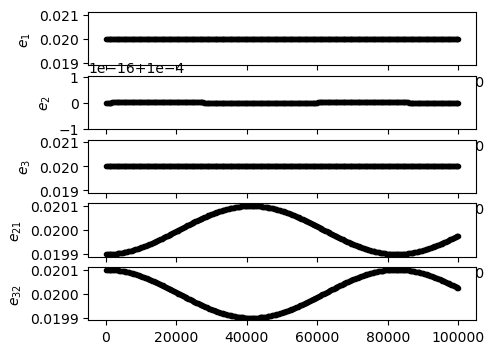

In [96]:
amp1, amp2, amp3, phase1, phase2, phase3, omega2, omega3 = GtoS(alpha, mass, ecc, pomega)
# ecc, pomega = StoG(mass, (0, amp2, 0), (phase1, phase2, phase3))
# print(ecc)
# print(pomega)
print(amp1, amp2, amp3)
plotEcc(alpha, mass, ecc, pomega,1e5)

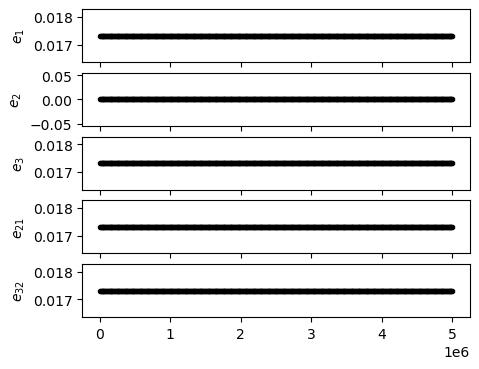

In [62]:
# A2, A3, theta = breathingON1(mass,amp3)
# print(theta)
# ecc, pomega = StoG(mass, (amp1, A2, A3), (phase1, phase2, phase2+theta))
plotEcc(alpha, mass, ecc, pomega, 5e6)